In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [57]:
from collections import namedtuple
from datetime import datetime

import numpy as np

from hmmlearn.hmm import GaussianHMM

import warnings
warnings.filterwarnings('ignore')

In [14]:
DATE_FORMAT = '%d.%m.%Y %H:%M:%S.%f'

DataPoint = namedtuple("DataPoint", "ts, value")

def read_simple_dataset(data_file, keep_target=False):
    data_points, changepoints, targets = [], [], []
    data_length = int(data_file.readline().strip())
    for iteration in xrange(data_length):
        results = read_simple_dataset_once(data_file, keep_target=keep_target)
        data_points.append(results[0])
        changepoints.append(results[1])
        if keep_target:
            targets.append(results[2])
    if keep_target:
        return data_points, changepoints, targets
    else:
        return data_points, changepoints


def read_simple_dataset_once(data_file, keep_target=False, data_length=None):
    time_series, cp_list, target = [], [], []
    if None is data_length:
        time_series_length = int(data_file.readline().strip())
    else:
        time_series_length = data_length
    is_changepoint = False
    for point_index in xrange(time_series_length):
        ts, value, is_current_changepoint = data_file.readline().strip().split('\t')
        is_current_changepoint = int(is_current_changepoint)
        ts = datetime.strptime(ts, DATE_FORMAT)
        time_series.append(DataPoint(ts, float(value)))
#         if is_changepoint != is_current_changepoint:
#             cp_list.append(ChangepointEvent(ts, None))
        is_changepoint = is_current_changepoint
        target.append(int(is_current_changepoint))
    if keep_target:
        return time_series, cp_list, target
    else:
        return time_series, cp_list

**Считаем искусственные данные**

In [43]:
with open('data/hard.train_data') as data_file:
    data_points, changepoints = read_simple_dataset(data_file)

In [44]:
timestamps = [point.ts for point in data_points[0]]
values = [point.value for point in data_points[0]]

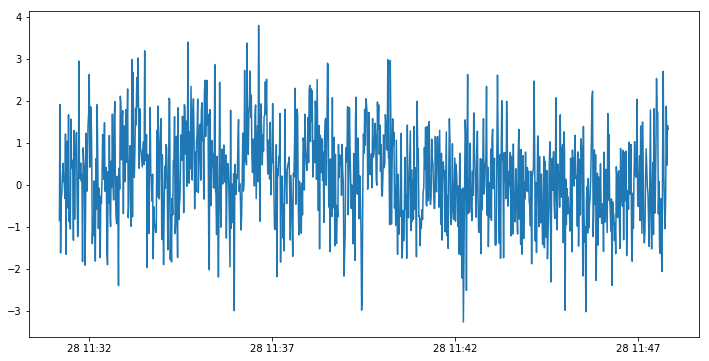

In [45]:
figure(figsize=(12, 6))
plot(timestamps, values)

In [52]:
values = np.reshape(values, (1, -1)).T

In [58]:
model = GaussianHMM(n_components=4,
                    covariance_type="diag",
                    n_iter=1000)
model.fit(values)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=4, n_iter=1000, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

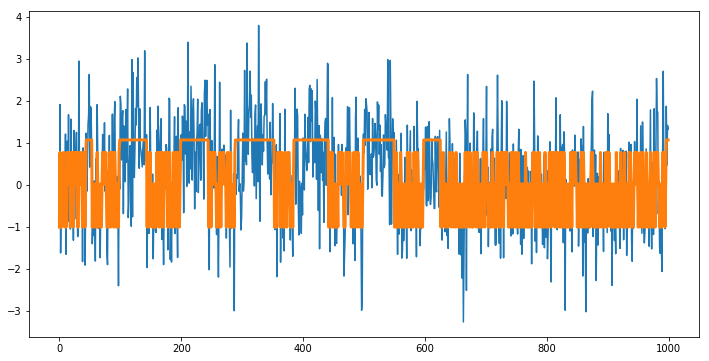

In [62]:
labels = model.predict(values)
means = np.zeros_like(values)
for i in xrange(4):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3)

Эксперименты:
 * поварьировать число компонент HMM,
 * Для обучения HMM необходимо задать какое-то начальное приближение ее параметров. В этот процесс можно вмешаться с помощью явного задания априорного распределения с помощью спецификации model.transmat_. Другие параметры модели доступны по `model.<TAB>`
 * HMM обучается на основе градиентного спуска в пространстве параметров (оптимизируется правдоподобие выборки). Различные инициализации приводят (в общем случае) к различным результатам оптимизации. Попробуйте обучить набор моделей HMM для понимания, насколько устойчиво обучение. Посмотрите на model.score(X) для оценки логарифма правдоподобия обучающей выборки.
 * Число итераций, заданное для обучения, влияет на качество модели. Модель будет продолжать оптимизацию, пока не прошло n_iter шагов градиентного спуска или пока изменение score выше, чем заданный порог tol. Заметьте, что в зависимости от используемых данных модель может и не окончить оптимизацию за n_iter шагов.

**Загрузим реальные финансовые данные для теста.**

In [63]:
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2013, 1, 27)
f = web.DataReader("F", 'google', start, end)

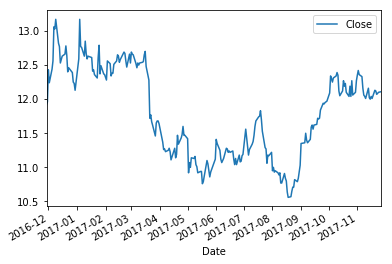

In [64]:
f.plot(y='Close')
plt.show()

In [65]:
X = f['Close'].values
X = X.reshape(-1, 1)

In [66]:
model = GaussianHMM(n_components=4, covariance_type="diag", n_iter=1000).fit(X)

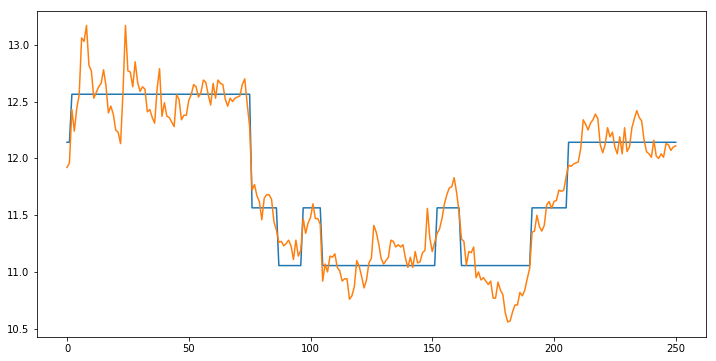

In [73]:
y_pred = model.predict(X)
X_pred = np.zeros_like(X)
for i in xrange(4):
    X_pred[y_pred == i] = model.means_[i]

plt.figure(figsize=(12, 6))
plt.plot(X_pred)
plt.plot(X)
plt.show()

Эксперименты:
 * поварьировать число компонент HMM,
 * Для обучения HMM необходимо задать какое-то начальное приближение ее параметров. В этот процесс можно вмешаться с помощью явного задания априорного распределения с помощью спецификации model.transmat_. Другие параметры модели доступны по `model.<TAB>`
 * HMM обучается на основе градиентного спуска в пространстве параметров (оптимизируется правдоподобие выборки). Различные инициализации приводят (в общем случае) к различным результатам оптимизации. Попробуйте обучить набор моделей HMM для понимания, насколько устойчиво обучение. Посмотрите на model.score(X) для оценки логарифма правдоподобия обучающей выборки.
 * Число итераций, заданное для обучения, влияет на качество модели. Модель будет продолжать оптимизацию, пока не прошло n_iter шагов градиентного спуска или пока изменение score выше, чем заданный порог tol. Заметьте, что в зависимости от используемых данных модель может и не окончить оптимизацию за n_iter шагов.